# Homework - Reinforcement Learning - Part B (60/100 points)

by *Todd Gureckis* and *Brenden Lake*  
Computational Cognitive Modeling  
NYU class webpage: https://brendenlake.github.io/CCM-site/  
email to course instructors: instructors-ccm-spring2019@nyuccl.org

<div class="alert alert-danger" role="alert">
  This homework is due before midnight on March 23, 2020.  
</div>

---

## Learning and deciding in an unknown world

[Part A](Homework-RL-A.ipynb) of the homework explored various solution to a sequential decision making problem in a case where considerable information about the environment was known or was provided (e.g., the probabilities of transitioning between different states and the magnitude of rewards available in particular states).  However, if reinforcement learning could only be applied to cases with full, explicit knowledge then it would be much less of a compelling model of human learning.  In many cases, humans and other animals learn even when there is much more ambiguity, and as a result, a good model of experiential learning for humans would apply to cases where less is known a-priori about the world.

<img src="images/bandit.jpg" width="200">

In this part of the homework, we will shift to think about learning and deciding in a unknown environment.  This is a fairly complex topic with many different solutions and types of problems.  However, we will focus on one particular problem class known as the **n-armed bandit**.  N-armed bandits are optimization problems that mimic many real-world problems faced by humans, organizations, and machine learning agents.  The term "bandit" comes from the name of the casino games where you pull a lever to enter a lottery.  The bandits have one arm (the arm you pull down) and they steal your money (see above).

<img src="images/multiarmedbandit.jpg" width="300">

An N-armed bandit is a problem where a decision maker is presented with a bandit with $n$ arms instead of just one (see Octopus cartoon).  The task for the agent is, on each trial or moment in time, to choose bandits that are good while avoiding those that are less good.  Since nothing may be known about the bandits a-priori, the problem is difficult and requires a balance of *exploration* (trying new things in order to learn) and *exploitation* (choosing options known to be good).

If each bandit paid out a fixed amount every time it was selected, then the problem would be solved with very simple exhaustive search process (visit each bandit once and then select the best one for the remaining time). However, the sequential search strategy just described doesn't capture the *opportunity cost* of exploration.  For example, imagine that there is 100 armed bandits.  Further assume that you know that 98 give zero reward, one gives a reward of 10, and one gives a reward of 20.  If on the first pull you receive 10 units of reward then you are lucky and landed on a good one.  However, is it worth going searching for the 20 point bandit?  Given that you will have to pull a lot of zero reward bandits, it might actually be more rewarding over a finite period to continue to pull the 10 point bandit arm.  Thus, exploration and exploitation act more like a tradeoff depending on the structure of the problem.

In addition, when the reward received from each bandit is probabilistic or stochastic, and furthermore the quality of the bandits might change over time, the problem becomes much more difficult.  These cases require the agent to learn from the past but also be willing to adjust their beliefs based on more recent information.

Bandit tasks come up in many areas of cognitive science and machine learning.  For example, there is a way to view A/B testing on websites as a [particular type of bandit problem](https://www.amazon.com/Bandit-Algorithms-Website-Optimization-Developing/dp/1449341330) (your goal is to ensure conversions or purchases on your website, and your bandit arms are the different web designs you might try out).  Similarly, the very real human problem of deciding where to eat lunch is a bit like a bandit problem -- should you return to your favorite restuarant or try a new one?  Is the exploration worth giving up a reliably good meal?

In this part of the homework you will explore different simple algorithms for bandit problems.

### Starter code

<div class="alert alert-warning" role="alert">
  <strong>Warning!</strong> Before running other cells in this notebook you must first successfully execute the following cell which includes some libraries.
</div>

In [64]:
# The typical imports
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt 
import random
import math
import seaborn as sns

## A simple bandit environment

The first class provided here creates a set of simple, stationary multi-arm bandits.  The bandits are stateless in that the reward from choose each action is simply a probabilistic function of the bandit itself, and there are no other cues you can use to decide which action to take.  The parameters to the constructor of the bandit environment are:  

- `mus`: the mean of the distribution from which each bandit is drawn from.  This should have k numbers (for the k-armed bandit)
- `sds`: the standard deviation of the distribution from which the bandit means are drawn from (also k numbers for k bandits)

In [65]:
class KArmBanditStationary():
    def __init__(self, mus, sds):
        self.action_means = mus
        self.action_sds = sds
        self.optimal = np.argmax(self.action_means)
        self.k = len(mus)
        
    def step(self, action):
        return np.random.normal(self.action_means[action], self.action_sds[action]), action==self.optimal

Your job in this first exercise is to write a simple RL agent which samples from these bandits and attempts to earn as much reward as possible.  The following cell gives an example of how to initialize the bandit and how to draw from it

In [66]:
bandit = KArmBanditStationary([0,50,10,4],[10,10,10,10])
action = 0 # pull the 0th bandit
bandit.step(action)  # return values are the reward, and if the action is actually optimal or not

(12.160349580355046, False)

When we initialize the `KArmBanditStationary` we in some sense know exactly which arm is optimal (the one with the higher mean), and also how hard the problem is (the standard deviation of the rewards on each arm determines the difficulty... low SD generally is a easier task due to signal-noise relationship).

However, we are going to be implementing agents that do not have access to this information.  For example, this first cell implements a simple random agent.  You will want to modify this class to create an agent that can learn.

In [67]:
class RandomAgent():
    def __init__(self, k):
        self.num_actions = k
        # you could add parameters to your agent here
        pass
    
    def choose(self):
        return np.random.randint(self.num_actions)
    
    def learn(self, reward, action): # this agent doesn't learn
        pass

This cell helps you plot the reward history including a smoothed average reward earned by the agents over the last 30 trials

In [68]:
def plot_results(results_df, window=25):
    # set up figiure
    palette = iter(sns.color_palette("Set2"))
    fig = plt.figure(constrained_layout=True,figsize=(18,5))
    gs = fig.add_gridspec(2,5)
    
    # add three axes
    rew_ax  = fig.add_subplot(gs[0,:-2]) 
    opt_ax  = fig.add_subplot(gs[1,:-2])
    runs_ax = fig.add_subplot(gs[:,-2:])
    
    #fig, (rew_ax,opt_ax) = plt.subplots(nrows=2,ncols=1,figsize=(18,8))
    smooth_df = results_df.groupby('run').rolling(window,on='timepoint').mean()
    sns.lineplot(x='timepoint',y='reward_history', data=smooth_df, ax=rew_ax, label='reward', color=next(palette))
    rew_ax.legend(loc="upper right")

    sns.lineplot(x='timepoint',y='opt', data=smooth_df, ax=opt_ax, label='p(optimal)', color=next(palette))
    opt_ax.set_ylim(0,1)
    opt_ax.legend(loc="upper right")
    
    sns.distplot(results_df.groupby('run')['opt'].mean(), ax=runs_ax, color=next(palette))
    runs_ax.set_title("proportion optimal choices across runs")
    runs_ax.set_xlim(0,1)
    


Finally, this is an example of the random agent's performance in the environment.

In [69]:
np.random.seed(100) # fix a seed for repeatable experiments

# parameters of simulation
n_timesteps = 300
n_runs = 500

# set up bandit options
n_bandits = 4
bandit_means = [0,50,10,4]
bandit_sds = [1]*n_bandits

/Users/qinyulu/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


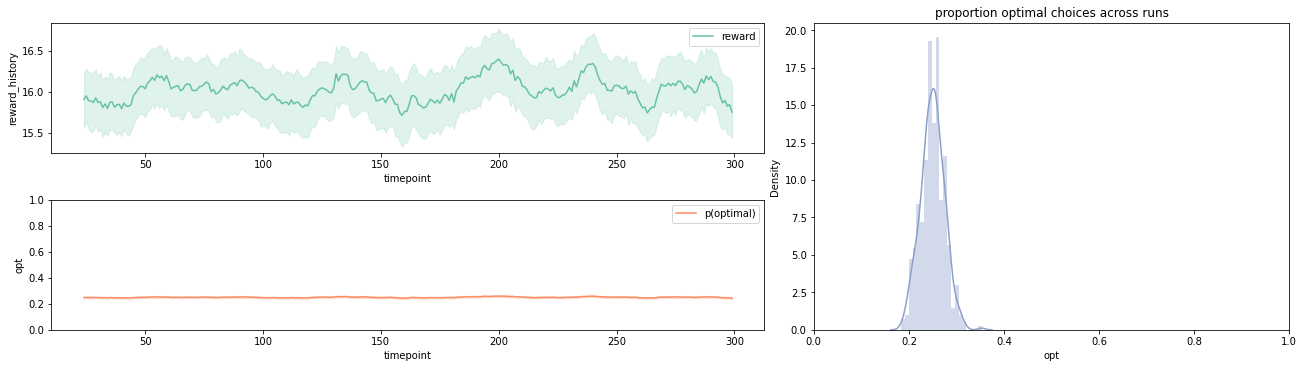

In [70]:
reward_history = []
opt_history = []
run_history = []
timestep = []

for run in range(n_runs):  # repeat a given number random repetitions of the experiment
    agent = RandomAgent(n_bandits)
    np.random.shuffle(bandit_means) # randomize location of "best"
    bandit = KArmBanditStationary(bandit_means,bandit_sds) # create a new bandit
    for i in range(n_timesteps): # for a certain number of time steps
        choice = agent.choose() # let the agent choose
        reward, opt = bandit.step(choice)
        reward_history.append(reward)
        opt_history.append(opt)
        run_history.append(run)
        timestep.append(i)
# plot the results
sim_result_df=pd.DataFrame({"run": run_history, "timepoint": timestep, "reward_history":reward_history, "opt": opt_history})
plot_results(sim_result_df)

Here the plot shows the average reward earned for each trial fo the task across the repeated runs/experiments.  The lower panel shows the proportion of optimal choices made by the agent across trials.  The error bars on both of these plots are bootstrapped confidence intervals across runs of the agent.  Finally, the right panel shows a histogram of the proportion of optimal choices made across the runs.

Everything looks as expected here.  The random agent makes about the average reward of the task and chooses the optimal choice about 25% of the time.

Can you use what we have learned in lecture to do better?

<div class="alert alert-success" role="alert">
<h3> Problem 4 (15 points) </h3><br>
  Create a new agent class based on `RandomAgent` called `EpsilonGreedyAgentIncremental()` which keeps track of the average reward earned from each draw of the bandit.  This agent will include a parameter `epsilon` which will determine the probability of choosing a random action, otherwise it should choose the best so far.  To update the value of each bandit use the incremental implementation of mean-tracking which was first introduced on the slides blending monte carlo methods (this is a incremental approach to calculating the mean as a new observation arrive).  Make a plot similar to the ones above showing the performance of the agent on the three measures we have considered when the environment is initialized in the same way (i.e., means are a random shuffling of [0.,50.,10.,4.] with sd=1).  Next, show with a couple examples how changes in epsilon determine the shape of that plot.  You should show the final code for your agent and the plots along with a single markdown cell describing your solution (1-2 paragraphs).  In your answer be sure to explain if your new agent does better than the random agent and why you think that is the case.  In all cases run your agent for 300 time steps and average over 500 runs.
</div>

/Users/qinyulu/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/qinyulu/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/qinyulu/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

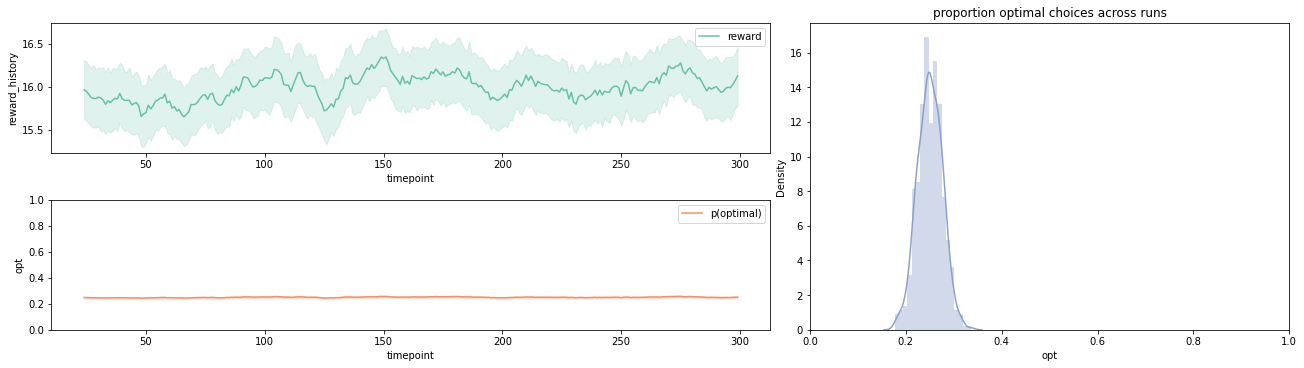

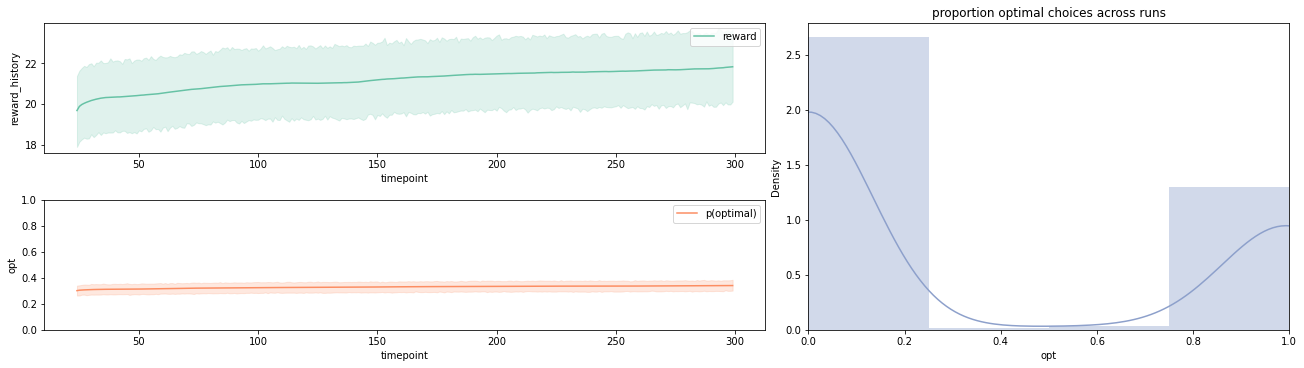

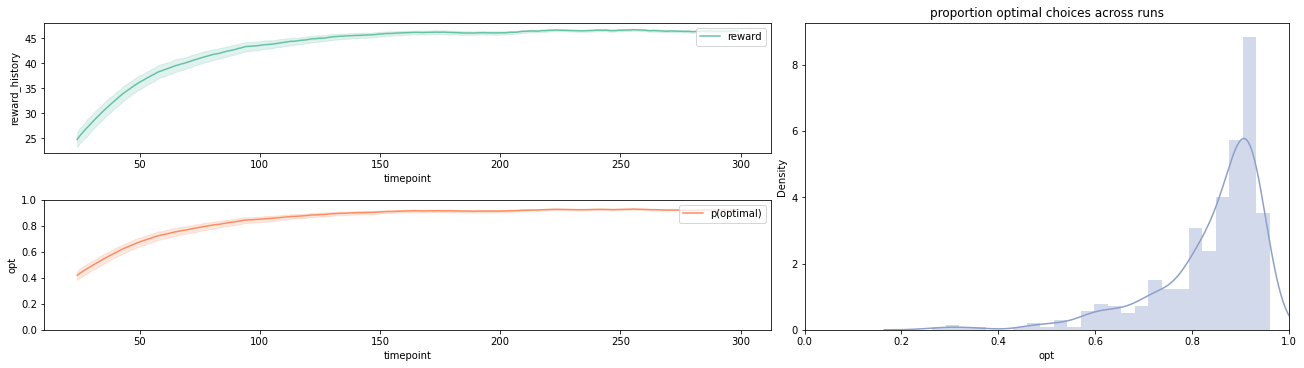

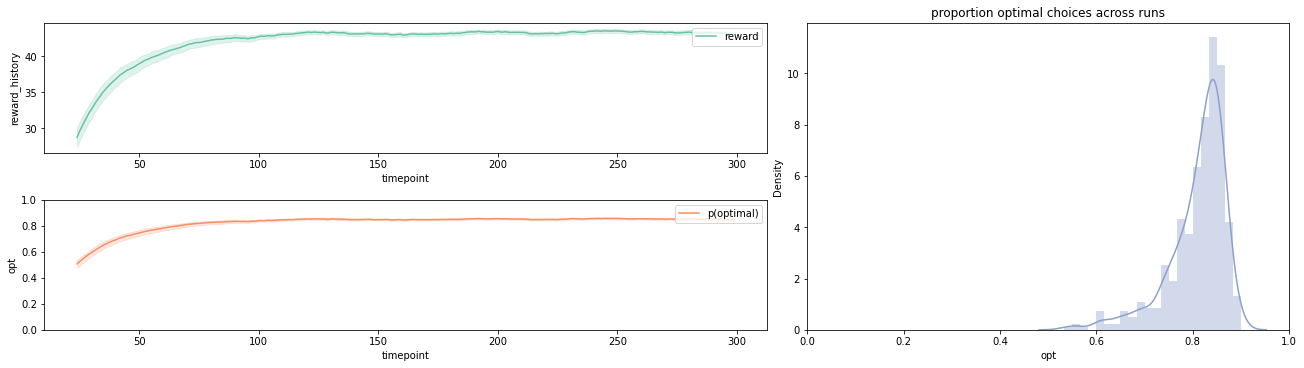

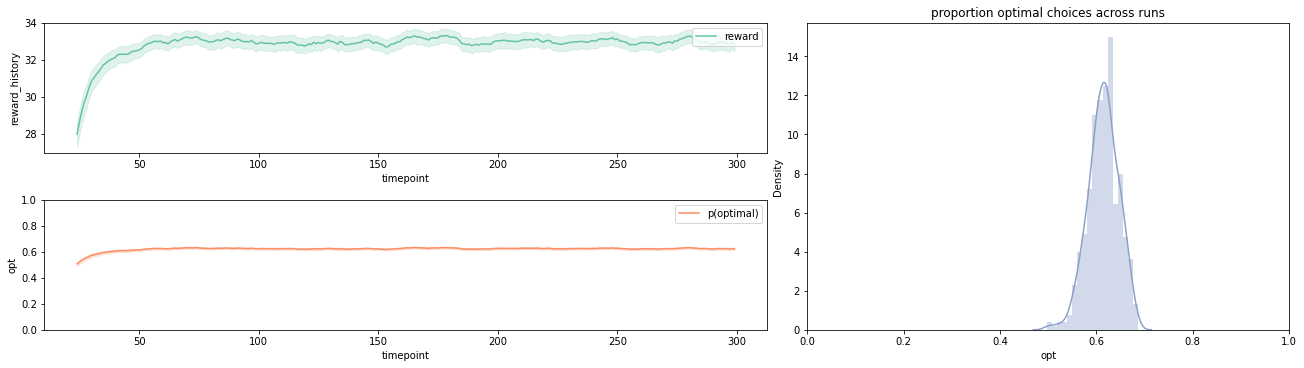

In [103]:
class EpsilonGreedyAgentIncremental():
    def __init__(self, k, ep):
        self.num_actions = k
        self.q_value = [0]*k
        self.n = [0]*k
        self.epsilon = ep
        # you could add parameters to your agent here
        # pass
    
    def choose(self):
        if random.random() < self.epsilon:
            return np.random.randint(self.num_actions)
        else:
            return np.argmax(self.q_value)
    
    def learn(self, reward, action): # this agent doesn't learn
        # pass
        prev_qvalue = self.q_value[action]
        if self.n[action] is not 0:
            self.q_value[action] = prev_qvalue + 1/self.n[action] * (reward - prev_qvalue)
        
    def increment_n(self, action):
        self.n[action] = self.n[action] + 1

epsilon = [1, 0.001, 0.1, 0.2, 0.5]
for ep in epsilon:
    reward_history = []
    opt_history = []
    run_history = []
    timestep = []
    for run in range(n_runs):  # repeat a given number random repetitions of the experiment
        agent = EpsilonGreedyAgentIncremental(n_bandits, ep)
        np.random.shuffle(bandit_means) # randomize location of "best"
        bandit = KArmBanditStationary(bandit_means,bandit_sds) # create a new bandit
        for i in range(n_timesteps): # for a certain number of time steps
            choice = agent.choose() # let the agent choose
            agent.increment_n(choice)
            reward, opt = bandit.step(choice)
            agent.learn(reward, choice)
            reward_history.append(reward)
            opt_history.append(opt)
            run_history.append(run)
            timestep.append(i)

    # plot the results
    sim_result_df=pd.DataFrame({"run": run_history, "timepoint": timestep, "reward_history":reward_history, "opt": opt_history})
    plot_results(sim_result_df)

### Explanation:

When epsilon = **1**, the first plot has the same result as the random agent(as it chooses only based on random choice). I tried 4 more values of epsilon: **0.001, 0.1, 0.2, 0.5.** From the above plots we can see when epsilon is in the range of (0.1, 0.2), it gives the best result. When is it too small(too less exploration when epsilon = 0.001) or too big(too much exploration when epsilon = 0.5), it does not yield favorable results. 

This agent has done much better than the random agent for two reasons. Impirically from the plots above, it yield better results. Theorectically, this agent update the q-values of each action incrementally and learn from its choices and experiences. 

<div class="alert alert-success" role="alert">
<h3> Problem 5 (15 points) </h3><br> 
Create a new agent class based on `RandomAgent` called `EpsilonGreedyAgentConstant()` which keeps track of the average reward earned from each draw of the bandit.  This agent will be nearly identical to `EpsilonGreedyIncremental()`.  However, in addition to the parameter `epsilon` which will determine the probability of choosing a random action, this agent should use the "constant step size" update rule related to temporal-different learning to update the value of each action.  The step size parameter (`alpha`) should be added as a new input parameter to your agent (hint: small values of this parameter are often better).   Make a plot similar to the ones above showing the performance of the agent on the three measures we have considered.  Is the performance of this agent the same or different than the previous agent you coded for this environment?  Try a few parameter combinations with your agent and in your response show 1-2 examples to help make your point.  You should show the final code for your agent and the plots along with a single markdown cell describing your solution (1-2 paragraphs). Be sure that your answer includes the answer to this key question: Does the constant agent out perform the incremental agent?  And does it do better than the random agent?  You don't need to do statistics but just a general visual comparison of the quality of the algorithsm is enough.  In all cases run your agent for 300 time steps and average over 500 runs.
</div>

In [108]:
class EpsilonGreedyAgentConstant():
    def __init__(self, k, ep):
        self.num_actions = k
        self.q_value = [0]*k
        self.epsilon = ep
        self.alpha = 0.2
        # you could add parameters to your agent here
        # pass
    
    def choose(self):
        if random.random() < self.epsilon:
            return np.random.randint(self.num_actions)
        else:
            return np.argmax(self.q_value)
    
    def learn(self, reward, action): # this agent doesn't learn
        # pass
        prev_qvalue = self.q_value[action]
        self.q_value[action] = prev_qvalue + self.alpha * (reward - prev_qvalue)

/Users/qinyulu/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/qinyulu/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/qinyulu/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

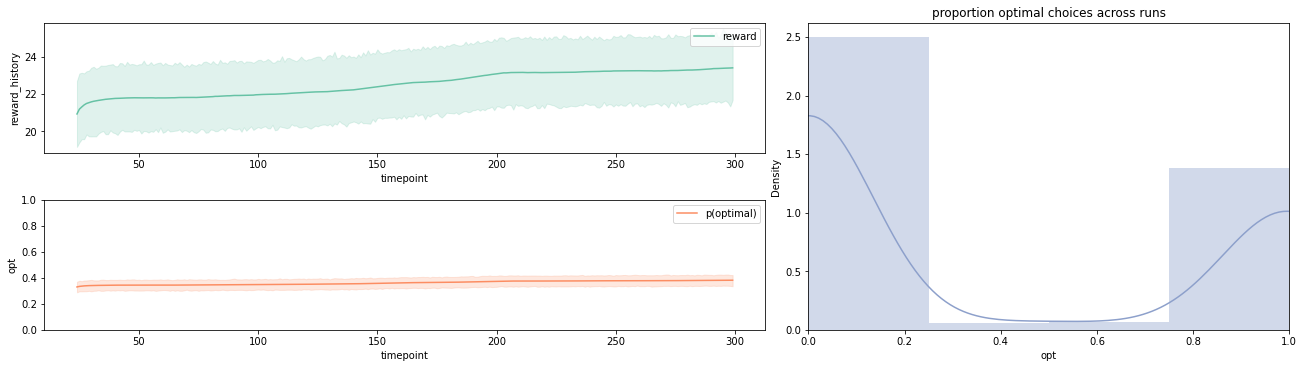

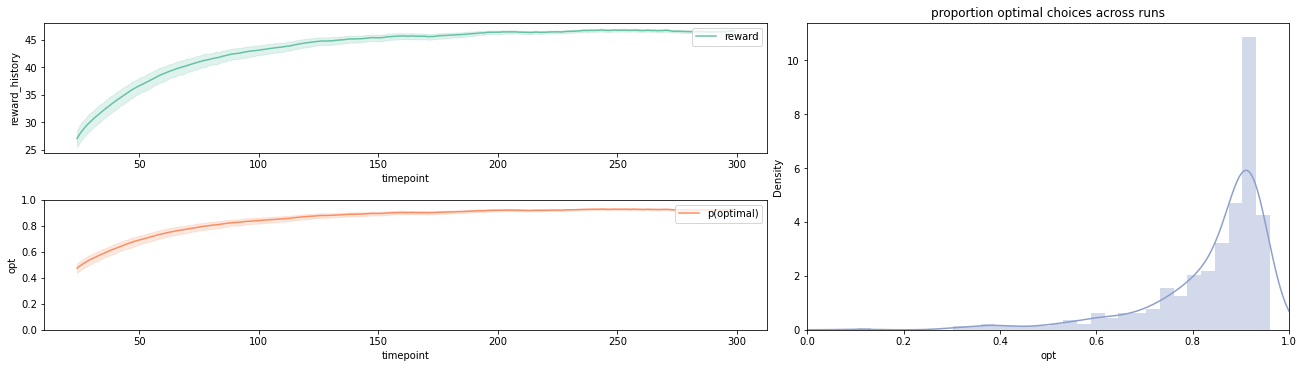

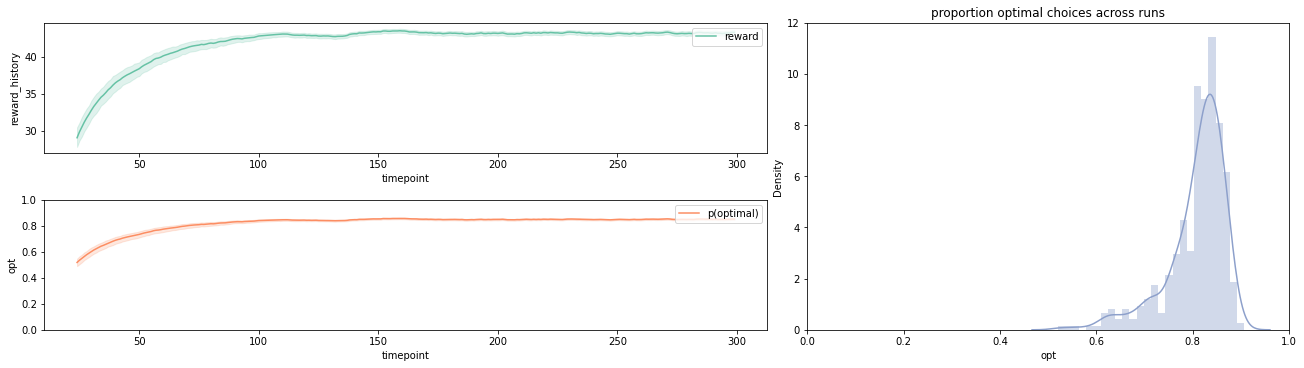

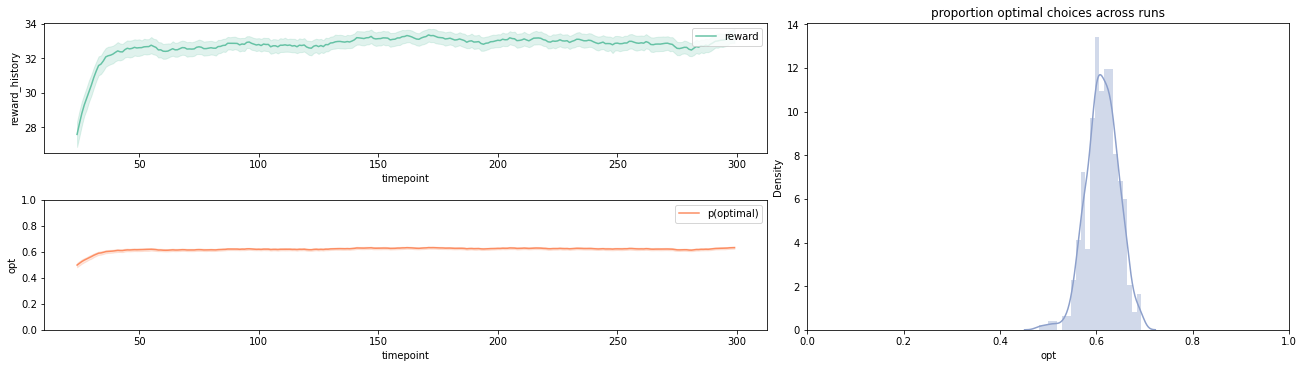

In [109]:
epsilon = [0.001, 0.1, 0.2, 0.5]
for ep in epsilon:
    reward_history = []
    opt_history = []
    run_history = []
    timestep = []

    for run in range(n_runs):  # repeat a given number random repetitions of the experiment
        agent = EpsilonGreedyAgentConstant(n_bandits, ep)
        np.random.shuffle(bandit_means) # randomize location of "best"
        bandit = KArmBanditStationary(bandit_means,bandit_sds) # create a new bandit
        for i in range(n_timesteps): # for a certain number of time steps
            choice = agent.choose() # let the agent choose
            reward, opt = bandit.step(choice)
            agent.learn(reward, choice)
            reward_history.append(reward)
            opt_history.append(opt)
            run_history.append(run)
            timestep.append(i)

    # plot the results
    sim_result_df=pd.DataFrame({"run": run_history, "timepoint": timestep, "reward_history":reward_history, "opt": opt_history})
    plot_results(sim_result_df)

### Explanation:
#### Compare with `EpsilonGreedyAgentIncrecmental()`
Here, I tried the same combination of epsilon values as the `EpsilonGreedyAgentIncrecmental()` . As comparing the plots, I think they give similar results. No dramatic difference has been observed. Similarly, the best results lie in between epsilon = `0.1` and `0.2`.
I set alpha = `0.2`(I compared 0.2 with 0.5, no drastic difference was observed).

#### Compare with `RandomAgent()`
From the plots, we can easily see it outperforms the random agent. 

<div class="alert alert-success" role="alert">
<h3> Problem 6 (15 points) </h3><br> 
      Below is a new type of bandit environment based on `KArmBanditStationary` class where the reward probabilities of each bandit change over time.  This is sometimes known as a "restless bandit" (see the Daw et al. 2013 paper on explore exploit mentioned in Lecture).  The idea is that on each time step the mean reward of each action should be modified up or down by a sample from a Gaussian distribution (e.g.,  $\mu_{t+1} = \mu_{t} + \mathcal{N}(0,20)$).  I have called the new class `KArmBanditRestless`.  The mean of the arms is itself drawn intiailly from a random normal distribution as well. Using this environment (with the number of arms set to 4), test the `RandomAgent()`, `EpsilonGreedyAgentConstant()` and I have called the new class `KArmBanditRestless`. The mean of the arms is itself drawn intiailly from a random normal distribution as well. Using this environment (with the number of arms set to 4), test the `RandomAgent()`, `EpsilonGreedyAgentConstant()` and `EpsilonGreedyAgentIncremental()` agents. You may want to play with the alpha parameter of the incremental agent to see if you can find a particularly good setting. Show the final code for your agent, plots showing the average reward the agent earns over time, along with a markdown cell describing your solution in 1-2 paragraphs. Which agent performs better in this environment? Is this different than the conclusion you made from the previous environment? Be sure to answer these two questions in your response. In all cases run your agent for 300 time steps and average over 500 runs.I have called the new class `KArmBanditRestless`. The mean of the arms is itself drawn intiailly from a random normal distribution as well. Using this environment (with the number of arms set to 4), test the `RandomAgent()`, `EpsilonGreedyAgentConstant()` and `EpsilonGreedyAgentIncremental()` agents. You may want to play with the alpha parameter of the incremental agent to see if you can find a particularly good setting. Show the final code for your agent, plots showing the average reward the agent earns over time, along with a markdown cell describing your solution in 1-2 paragraphs. Which agent performs better in this environment? Is this different than the conclusion you made from the previous environment? Be sure to answer these two questions in your response. In all cases run your agent for 300 time steps and average over 500 runs.`EpsilonGreedyAgentIncremental()` agents.  You may want to play with the alpha parameter of the incremental agent to see if you can find a particularly good setting.  Show the final code for your agent, plots showing the average reward the agent earns over time, along with a  markdown cell describing your solution in 1-2 paragraphs.  Which agent performs better in this environment?  Is this different than the conclusion you made from the previous environment? Be sure to answer these two questions in your response.  In all cases run your agent for 300 time steps and average over 500 runs.
</div>

In [133]:
# parameters of simulation
n_timesteps = 300
n_runs = 500

class KArmBanditRestless():
    def __init__(self, k, mu=0, sigma=2, sd=2, walk_sd=30):
        self.k = k
        self.action_means = np.random.normal(mu, sigma, k)
        self.action_sds = sd
        self.walk_sd = walk_sd
        self.optimal = np.argmax(self.action_means)
        
    def step(self, action):
        out = np.random.normal(self.action_means[action], self.action_sds), action==self.optimal
        self.action_means = self.action_means + np.random.normal(0.0, self.walk_sd, self.k)
        self.optimal = np.argmax(self.action_means)
        return out

In [134]:
# intialize this bandit like this
n_bandits = 4
bandit = KArmBanditRestless(n_bandits)

/Users/qinyulu/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


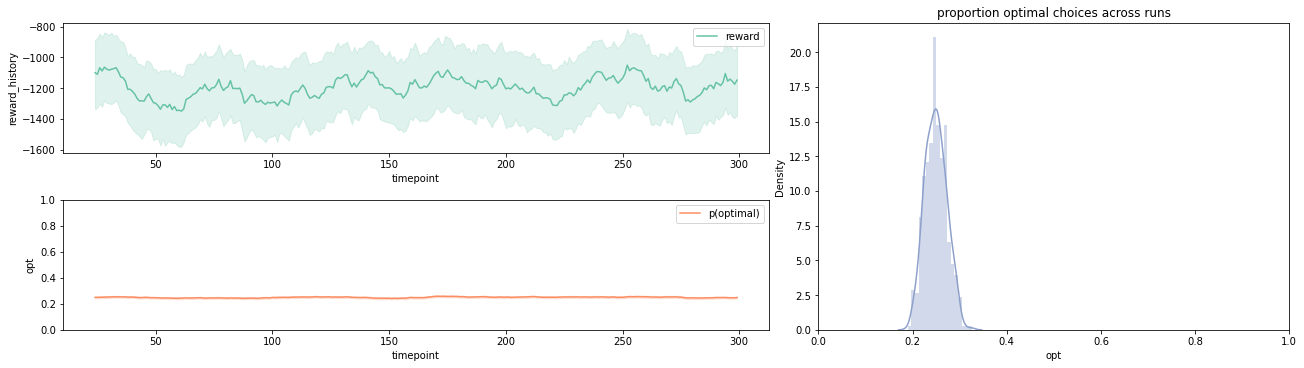

In [135]:
# Random
reward_history = []
opt_history = []
run_history = []
timestep = []

for run in range(n_runs):  # repeat a given number random repetitions of the experiment
    agent = RandomAgent((n_bandits))
    for i in range(n_timesteps): # for a certain number of time steps
        choice = agent.choose() # let the agent choose
        reward, opt = bandit.step(choice)
        agent.learn(reward, choice)
        reward_history.append(reward)
        opt_history.append(opt)
        run_history.append(run)
        timestep.append(i)
    
# plot the results
sim_result_df=pd.DataFrame({"run": run_history, "timepoint": timestep, "reward_history":reward_history, "opt": opt_history})
plot_results(sim_result_df)

/Users/qinyulu/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


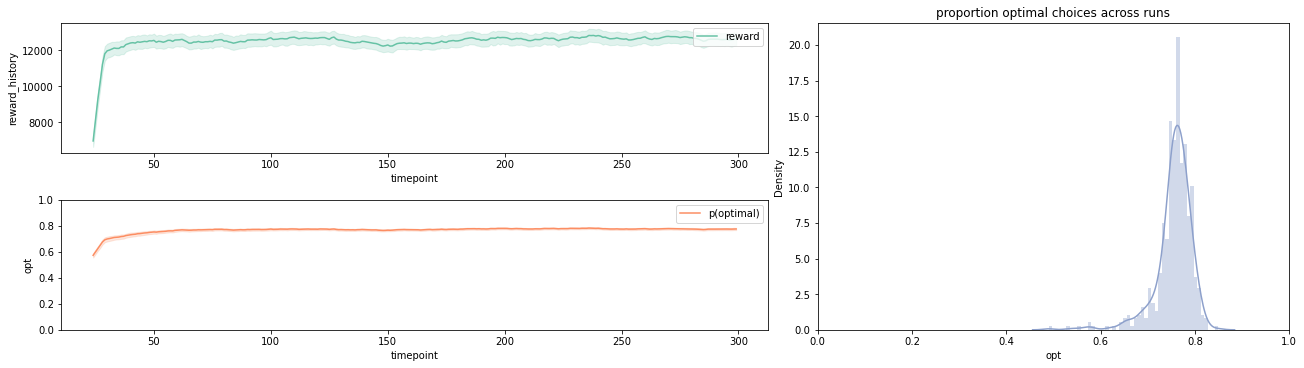

In [136]:
# EpsilonGreedyAgentIncremental
reward_history = []
opt_history = []
run_history = []
timestep = []

for run in range(n_runs):  # repeat a given number random repetitions of the experiment
    agent = EpsilonGreedyAgentIncremental(n_bandits, 0.3)
    for i in range(n_timesteps): # for a certain number of time steps
        choice = agent.choose() # let the agent choose
        reward, opt = bandit.step(choice)
        agent.learn(reward, choice)
        agent.increment_n(choice)
        reward_history.append(reward)
        opt_history.append(opt)
        run_history.append(run)
        timestep.append(i)
    
# plot the results
sim_result_df=pd.DataFrame({"run": run_history, "timepoint": timestep, "reward_history":reward_history, "opt": opt_history})
plot_results(sim_result_df)

/Users/qinyulu/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


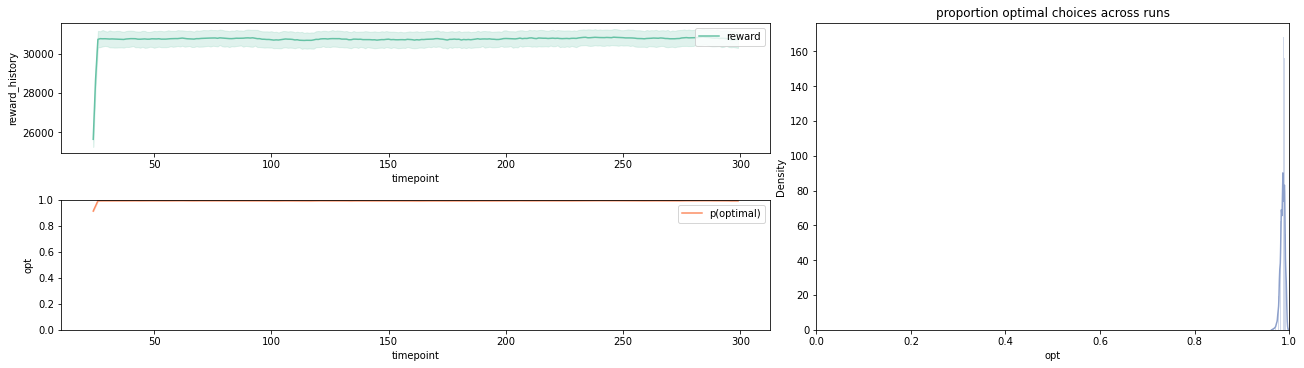

In [137]:
# EpsilonGreedyAgentConstant
reward_history = []
opt_history = []
run_history = []
timestep = []

for run in range(n_runs):  # repeat a given number random repetitions of the experiment
    agent = EpsilonGreedyAgentConstant(n_bandits, 0.01)
    for i in range(n_timesteps): # for a certain number of time steps
        choice = agent.choose() # let the agent choose
        reward, opt = bandit.step(choice)
        agent.learn(reward, choice)
        reward_history.append(reward)
        opt_history.append(opt)
        run_history.append(run)
        timestep.append(i)
    
# plot the results
sim_result_df=pd.DataFrame({"run": run_history, "timepoint": timestep, "reward_history":reward_history, "opt": opt_history})
plot_results(sim_result_df)

### Explanation: 
#### Comparing 3 agents
The above plots show the results of three agents `RandomAgent()`, `EpsilonGreedyAgentIncremental()` and `EpsilonGreedyAgentConstant()`correspondingly. In this environment, `EpsilonGreedyAgentConstant()` performs better. Yes, it is different from Problem 6. Since in this case, the environment varies more, new reward that the agent gets is equally important as the older ones. However for the `EpsilonGreedyAgentIncremental()``EpsilonGreedyAgentIncremental()`, as the number of times the agent has pulled the arm, the later pulls are less important than the older pulls, thus it cannot adapt to the environent and learn as efficient as the `EpsilonGreedyAgentConstant()` agent. 

#### Alpha
As for alpha, it represents the step size and mainly affects the speed of convergence. If it is bigger, the plot tends to converge faster, but if it's too large, it may not find the optimal solution. Alpha represents the step size, it mainly affects the speed of convergence. If it is bigger, the plot tends to converge faster, but if it's too large(oscillates too much), it may not be able to find the optimal solution. 

<div class="alert alert-success" role="alert">
<h3> Problem 7 (15 points) </h3><br>
 
For this problem, we return to the grid world task we considered in Part A.  Specifically, you should combine the ideas about explore-exploit and incremental learning of q-values to implement a temporal-difference solution the to grid world problem you explored in Part A of the homework.  You can reuse the code from that notebook in building your solution.  This solution should also obtain similar results to the policy-iteration and monte-carlo versions you explored, but is learned more incrementally and online.  

The basic setup of the GridWorld environment is provided again for you below.  Your solution to this problem should involve modifications to the solution to the Monte-Carlo problems in Part A.  In particular, instead of waiting until a particular episode ends to update the values of the Q-values, use the Q-learning equation to incrementally updates these values as an episode unfolds.  To balance exploration and exploitation try any of the methods you developed in the earlier parts of this assignment.

As a reminder the question for updating the Q values in Q-learning is as follows:

$Q(s,a) = Q(s,a) + \alpha [r +\gamma  max_{a'} Q(s',a') - Q(s,a)] $

The pseudo code for this algorithm is:
```
Initialize, for all $s \in S$, $a \in A(s)$:
    $Q(s,a)$ <- arbitrary

Repeat many times (for each episode):
    a) Initialize $s$ at the start state
    b) Repeat
        1. Choose action $a$ from $s$ using policy dervived from Q values in that state (e.g., SoftMax)
        2. Take action $a$, observe $r$, $s'$
        3. Update $Q(s,a)$
           Find max Q(s',a') over all action a' in state s'
           $Q(s,a) = Q(s,a) + \alpha [r + \gamma max Q(s',a') - Q(s,a)]$
           $s$ <- $s'$
       Until $s$ is the goal state
```


</div>

In [ ]:
# import the gridworld library
import numpy as np
import random
import math
import statistics
from copy import deepcopy
from IPython.display import display, Markdown, Latex, HTML
from gridworld import GridWorld, random_policy

In [ ]:
gridworld = [
       [ 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'x', 'g'],
       [ 'o', 'x', 'x', 'o', 'x', 'x', 'o', 'x', 'o'],
       [ 'o', 'x', 'x', 'o', 'x', 'x', 'o', 'x', 'o'],
       [ 'o', 'x', 'x', 'o', 'x', 'x', 'o', 'o', 'o'],
       [ 'o', 'x', 'x', 'o', 'x', 'x', 'x', 'o', 'o'],
       [ 's', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'x']
    ] # the problem described above, 'x' is a wall, 's' is start, 'g' is goal, and 'o' is a normal room


mygrid = GridWorld(gridworld)
mygrid.raw_print()  # print out the grid world
mygrid.index_print() # print out the indicies of each state
mygrid.coord_print() # print out the coordinates of each state (helpful in your code)

# define the rewards as a hash table
rewards={}

# mygrid.transitions contains all the pairwise state-state transitions allowed in the grid
# for each state transition intialize the reward to zero
for start_state in mygrid.transitions:
    for action in mygrid.transitions[start_state].keys():
        next_state = mygrid.transitions[start_state][action]
        rewards[str([start_state, action, next_state])] = 0.0

# now set the reward for moving up into state 8 (the goal state) to +10
rewards[str([17, 'up', 8])] = 10

# now set the penalty for walking off the edge of the grid and returning to state 45 (the start state)
for i in [0,1,2,3,4,5,6,7]:
    rewards[str([i, 'up', 45])] = -1
for i in [0,9,18,27,36,45]:
    rewards[str([i, 'left', 45])] = -1
for i in [45,46,47,48,49,50,51,52,53]:
    rewards[str([i, 'down', 45])] = -1
for i in [8,17,26,35,44,53]:
    rewards[str([i, 'right', 45])] = -1

In [ ]:
# this is a helper function that will take a set of q-values and convert them into a greedy decision strategy        
def be_greedy(q_values):
    if len(q_values)==0:
        return {}
    keys = list(q_values.keys())
    vals = [q_values[i] for i in keys]    
    maxqs = [i for i,x in enumerate(vals) if x==max(vals)]
    if len(maxqs)>1:
        pos = random.choice(maxqs)
    else:
        pos = maxqs[0]
    policy = deepcopy(q_values)
    for i in policy.keys():
        policy[i]=0.0
    policy[keys[pos]]=1.0
    return policy

In [ ]:
def epsilon_greedy(actions, epsilon):
    # 20 % of time random, 80% of time determined
    if random.random() < epsilon:
        return random.choice(list(actions.keys()))
    else:
        if actions['up']==1.0:
            return 'up'
        elif actions['right']==1.0:
            return 'right'
        elif actions['down']==1.0:
            return 'down'
        elif actions['left']==1.0:
            return 'left'

In [45]:
#recursively sample state-action transitions using epsilon greedy algorithm with a maximum recursion depth of 100.
def mc_episode(current_state, epsilon, goal_state, policy_table, q_value_table, alpha, GAMMA, depth=0, max_depth=100):
    step = depth
    while current_state!=goal_state and step<max_depth:
        sx, sy = mygrid.index_to_coord(current_state)
        action = epsilon_greedy(policy_table[sx][sy],epsilon)
        if action == 'up':
            new_state = mygrid.up(current_state)
        elif action == 'right':
            new_state = mygrid.right(current_state)
        elif action == 'down':
            new_state = mygrid.down(current_state)
        elif action == 'left':
            new_state = mygrid.left(current_state)
        new_x, new_y = mygrid.index_to_coord(new_state)
        r = rewards[str([current_state,action,new_state])]
        # print("new",  q_value_table[new_x][new_y])
        q_value_table[sx][sy][action] = q_value_table[sx][sy][action] + alpha * (r + GAMMA * max(q_value_table[new_x][new_y].values()) - q_value_table[sx][sy][action])
        step = step + 1
     
    return q_value_table

In [53]:
starting_state = 45
goal_state = 8 # terminate the MC roll out when you get to this state
GAMMA=0.9
EPSILON = 0.2
alpha = 0.9
ITERATIONS = 10000 # this may need to be 100,000 or more!
PRINT_EVERY = 1000 # how often to print out our progress
random.seed(5000) # try multiple random seed to verify your code works

# set up initial data strucutres that might be useful for you
# q(s,a) - the q-values for each action in each state
def zero_q_values():
    qvals = {"up": 0.0, "right": 0.0, "down": 0.0, "left": 0.0}
    return qvals
q_value_table = [[zero_q_values() for i in range(mygrid.ncols)] for j in range(mygrid.nrows)]

# pi - the policy table
policy_table = [[random_policy() for i in range(mygrid.ncols)] for j in range(mygrid.nrows)]
display(Markdown("**Initial (randomized) policy**"))
mygrid.pretty_print_policy_table(policy_table)

for i in range(ITERATIONS):  # you probably need to take many, many steps here and it make take some time to run
    # instead of always starting at the start state, this algorithm will use the concept of an 
    # "exploring start" so that it starts in a random valid state
    # this can help a lot
    ss = random.choice(list(mygrid.valid_states.keys()))  # select and exploring start state
    q_value_table = mc_episode(ss, EPSILON, goal_state, policy_table, q_value_table, alpha, GAMMA)

    if i%PRINT_EVERY==0:
        display(Markdown(f"**Improved policy interation {i}**"))
        mygrid.pretty_print_policy_table(policy_table)
        # mygrid.pretty_print_table(value_table)
        for sx in range(len(q_value_table)):
            for sy in range(len(q_value_table[sx])):
                policy_table[sx][sy] = be_greedy(q_value_table[sx][sy])

display(Markdown("**Improved policy**"))
mygrid.pretty_print_policy_table(policy_table)

**Initial (randomized) policy**

→,↓,←,←,↑,←,↑,▉,←
↓,▉,▉,←,▉,▉,→,▉,↓
←,▉,▉,↑,▉,▉,→,▉,→
↑,▉,▉,↑,▉,▉,↓,←,←
←,▉,▉,→,▉,▉,▉,↑,↓
↑,↓,↓,↑,←,←,↓,↓,▉


**Improved policy interation 0**

→,↓,←,←,↑,←,↑,▉,←
↓,▉,▉,←,▉,▉,→,▉,↓
←,▉,▉,↑,▉,▉,→,▉,→
↑,▉,▉,↑,▉,▉,↓,←,←
←,▉,▉,→,▉,▉,▉,↑,↓
↑,↓,↓,↑,←,←,↓,↓,▉


**Improved policy interation 1000**

→,→,→,↑,↓,↓,↓,▉,←
↑,▉,▉,←,▉,▉,↑,▉,←
↑,▉,▉,↓,▉,▉,←,▉,↓
↓,▉,▉,↓,▉,▉,←,↑,↓
↑,▉,▉,↓,▉,▉,▉,↓,↑
↑,↓,↓,→,→,←,→,↓,▉


**Improved policy interation 2000**

→,→,→,→,→,→,↓,▉,↓
↑,▉,▉,↑,▉,▉,↓,▉,↑
↑,▉,▉,↓,▉,▉,↓,▉,↑
↓,▉,▉,↓,▉,▉,→,→,↑
↓,▉,▉,↓,▉,▉,▉,↑,↑
→,→,→,→,→,→,→,↑,▉


**Improved policy interation 3000**

→,→,→,→,→,→,↓,▉,↓
↑,▉,▉,↑,▉,▉,↓,▉,↑
↑,▉,▉,↓,▉,▉,↓,▉,↑
↓,▉,▉,↓,▉,▉,→,→,↑
↓,▉,▉,↓,▉,▉,▉,→,↑
→,→,→,→,→,→,→,↑,▉


**Improved policy interation 4000**

→,→,→,→,→,→,↓,▉,←
↑,▉,▉,↑,▉,▉,↓,▉,↑
↑,▉,▉,↑,▉,▉,↓,▉,↑
↓,▉,▉,↓,▉,▉,→,→,↑
↓,▉,▉,↓,▉,▉,▉,→,↑
→,→,→,→,→,→,→,↑,▉


**Improved policy interation 5000**

→,→,→,→,→,→,↓,▉,↓
↑,▉,▉,↑,▉,▉,↓,▉,↑
↑,▉,▉,↓,▉,▉,↓,▉,↑
↓,▉,▉,↓,▉,▉,→,→,↑
↓,▉,▉,↓,▉,▉,▉,→,↑
→,→,→,→,→,→,→,↑,▉


**Improved policy interation 6000**

→,→,→,→,→,→,↓,▉,→
↑,▉,▉,↑,▉,▉,↓,▉,↑
↑,▉,▉,↑,▉,▉,↓,▉,↑
↓,▉,▉,↓,▉,▉,→,→,↑
↓,▉,▉,↓,▉,▉,▉,→,↑
→,→,→,→,→,→,→,↑,▉


**Improved policy interation 7000**

→,→,→,→,→,→,↓,▉,→
↑,▉,▉,↑,▉,▉,↓,▉,↑
↑,▉,▉,↓,▉,▉,↓,▉,↑
↓,▉,▉,↓,▉,▉,→,→,↑
↓,▉,▉,↓,▉,▉,▉,→,↑
→,→,→,→,→,→,→,↑,▉


**Improved policy interation 8000**

→,→,→,→,→,→,↓,▉,→
↑,▉,▉,↑,▉,▉,↓,▉,↑
↑,▉,▉,↑,▉,▉,↓,▉,↑
↓,▉,▉,↓,▉,▉,→,→,↑
↓,▉,▉,↓,▉,▉,▉,↑,↑
→,→,→,→,→,→,→,↑,▉


**Improved policy interation 9000**

→,→,→,→,→,→,↓,▉,↑
↑,▉,▉,↑,▉,▉,↓,▉,↑
↓,▉,▉,↓,▉,▉,↓,▉,↑
↓,▉,▉,↓,▉,▉,→,→,↑
↓,▉,▉,↓,▉,▉,▉,→,↑
→,→,→,→,→,→,→,↑,▉


**Improved policy**

→,→,→,→,→,→,↓,▉,↑
↑,▉,▉,↑,▉,▉,↓,▉,↑
↑,▉,▉,↑,▉,▉,↓,▉,↑
↓,▉,▉,↓,▉,▉,→,→,↑
↓,▉,▉,↓,▉,▉,▉,→,↑
→,→,→,→,→,→,→,↑,▉


<div class="alert alert-info" role="alert">
  
  The following code sets up the major things you need to track.  Note that unlike in the Monte Carlo solution you do not need a separate accounting of the returns as you are updating those to the Q-values directly.
  
  Also you shouldn't need to update the policy table until you have run many episodes through the maze.  The final update to the `policy_table` should just to be to print out your final greedy solution and compare it to the solutions you obtained in Part A.
 
</div>

### Summary
As compared the final policy to the one in Part A, they look very similar. However, online learning is much faster than the previous MC method. It updates to the optimal policy very quickly.

# Turning in homework

When you are finished with this notebook. Save your work in order to turn it in.  To do this select *File*->*Download As...*->*HTML*.

<img src="images/save-pdf.png" width="300">

You can turn in your assignments using NYU Classes webpage for the course (available on https://home.nyu.edu). **Make sure you complete all parts (A and B) of this homework.**